<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/Adversarial_Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet ADVERSARIAL ROBUSTNESS**

Dans ce projet nous allons faire tourner les codes présents dans ce lien https://adversarial-ml-tutorial.org/ et les implémenter avec un jeu de donnée différent

## **Chapter 1 - Introduction to adversarial robustness**

Nous avons modifié la photo de porc initiale

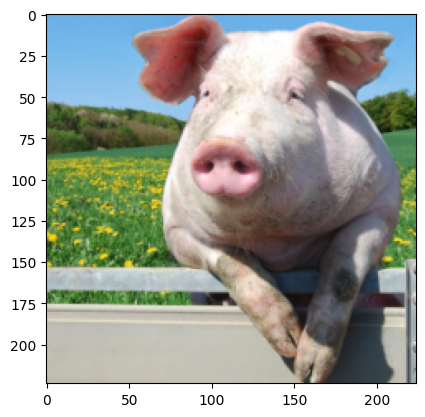

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

On pré-entraînne le modèle ResNet50

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.1MB/s]


In [ ]:
# form predictions
pred = model(norm(pig_tensor))

Nous avons modifié le code original qui ne fonctionnait pas et on l'a remplacé par ça

In [ ]:
import torchvision
import json
import urllib

# Télécharger le fichier si nécessaire
url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
class_index_path = 'imagenet_classes.txt'

urllib.request.urlretrieve(url, class_index_path)

# Lire les classes d'ImageNet directement depuis le fichier
with open(class_index_path) as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# Exemple d'utilisation avec une prédiction (remplace 'pred' par la vraie prédiction de ton modèle)
pred = torch.tensor([[0.1, 0.05, 0.8]])  # Exemple de prédiction simulée
predicted_class = pred.argmax(dim=1).item()  # Obtenir la classe prédite
print(f"Classe prédite : {imagenet_classes[predicted_class]}")


Classe prédite : great white shark


Entropie croisé

In [ ]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.005221302155405283


Création d'un exemple adversarial

In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.005221302155405283
5 -12.069189071655273
10 -20.85006332397461
15 -15.128918647766113
20 -26.62420654296875
25 -22.911529541015625
True class probability: 1.9602806045071475e-09


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  American Staffordshire terrier
Predicted probability: 0.9347768425941467


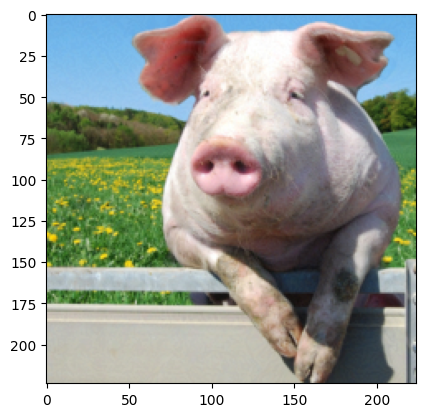

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

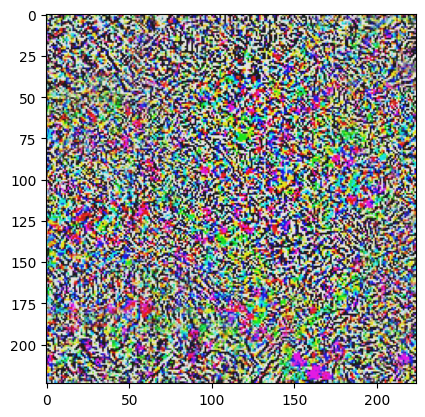

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

Attaques ciblées

In [ ]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 20.150226593017578
10 -7.942383766174316
20 -20.61503791809082
30 -30.38827896118164
40 -37.09360885620117
50 -42.06052017211914
60 -47.185787200927734
70 -49.58938217163086
80 -51.544334411621094
90 -52.898929595947266


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9999269247055054


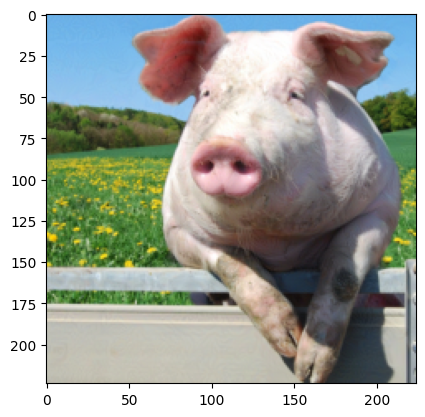

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Ajout d'un bruit d'avion de ligne

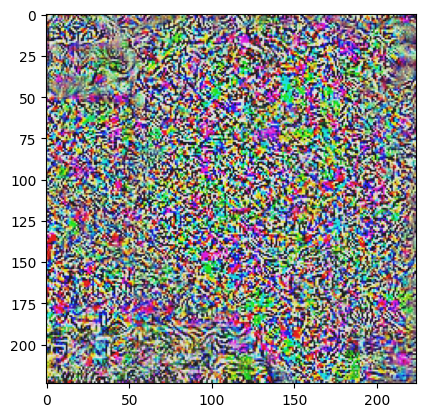

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

Les algorithmes de deep learning sont incroyablement fragiles, et les exemples adversariaux mettent ce fait en évidence de manière très claire et intuitive.

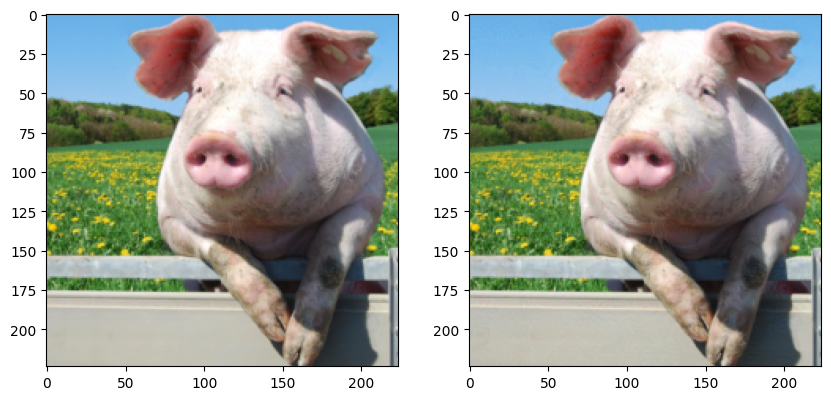

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

## **Chapter 2 - linear models**

Nous refaisons l'algorithme avec le jeu de données Fashion-MNIST au lieu du jeu de données MNIST. Fashion-MNIST est un jeu de données similaire à MNIST, mais il contient des images de vêtements (t-shirts, pantalons, etc.) plutôt que des chiffres.

Le code implémente une régression logistique pour un sous-ensemble du jeu de données Fashion-MNIST, en se concentrant uniquement sur les deux premières classes (T-shirts/hauts et pantalons), pour en faire un problème de classification binaire.

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim



# Charger les données Fashion-MNIST
fashion_train = datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
fashion_test = datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())

# Pour simplifier, on garde uniquement les deux premières classes (T-shirts/hauts et pantalons)
train_idx = fashion_train.targets <= 1
fashion_train.data = fashion_train.data[train_idx]
fashion_train.targets = fashion_train.targets[train_idx]

test_idx = fashion_test.targets <= 1
fashion_test.data = fashion_test.data[test_idx]
fashion_test.targets = fashion_test.targets[test_idx]

# Créer les DataLoaders
train_loader = DataLoader(fashion_train, batch_size=100, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=100, shuffle=False)

# Définir le modèle de régression logistique (réseau neuronal linéaire)
model = nn.Linear(784, 1)

# Définir l'optimiseur
opt = optim.SGD(model.parameters(), lr=1.)


# Fonction pour une seule passe sur les données
def epoch(loader, model, opt=None):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X = X.view(X.shape[0], -1)  # Redimensionner les images en vecteurs
        yp = model(X)[:, 0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())  # Perte binaire pour les deux classes
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y == 0) + (yp < 0) * (y == 1)).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Entraîner le modèle et évaluer sur les données de test
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

100%|██████████| 26.4M/26.4M [00:06<00:00, 4.34MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:04<00:00, 943kB/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.03MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train Err	Train Loss	Test Err	Test Loss
0.037583	0.213774	0.019000	0.053735
0.016250	0.047879	0.017500	0.043480
0.014250	0.042006	0.015000	0.042342
0.011917	0.039731	0.021500	0.057910
0.012250	0.036742	0.015000	0.036730
0.011500	0.034889	0.016000	0.038838
0.009833	0.031551	0.013500	0.034297
0.010000	0.031004	0.015500	0.037314
0.009750	0.030285	0.012000	0.033969
0.010583	0.031377	0.013000	0.033457


 Visualisation des prédictions et à génération d'exemples adversariaux pour un modèle de régression logistique

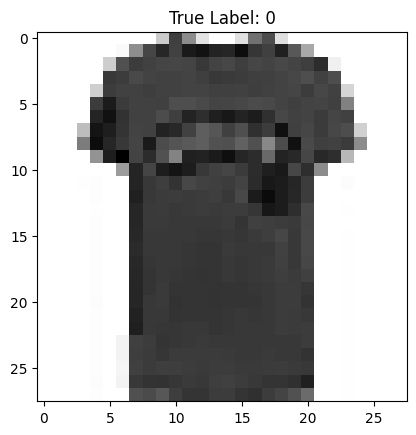

In [8]:
import matplotlib.pyplot as plt

# Modèle de régression logistique (linéaire)
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=0.1)


# Passer les images de test au format correct pour les utiliser avec le modèle
X_test = (test_loader.dataset.data.float() / 255).view(len(test_loader.dataset), -1)
y_test = test_loader.dataset.targets
yp = model(X_test)[:, 0]

# Filtrer les prédictions correctes
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
correct_idx = torch.nonzero(idx)[0].item()  # Sélectionner le premier indice correct

# Afficher l'image correspondante
plt.imshow(1 - X_test[correct_idx].view(28, 28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[correct_idx].item()))
plt.show()



 Une perturbation adversariale est générée en utilisant les poids du modèle.

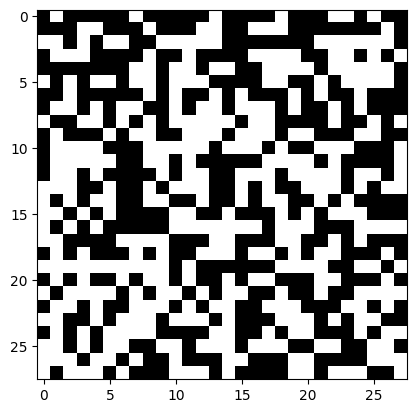

In [9]:
# Génération de perturbation adversariale
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28, 28)
plt.imshow(1 - delta.numpy(), cmap="gray")
plt.show()

(1.0, 2.714967119693756)


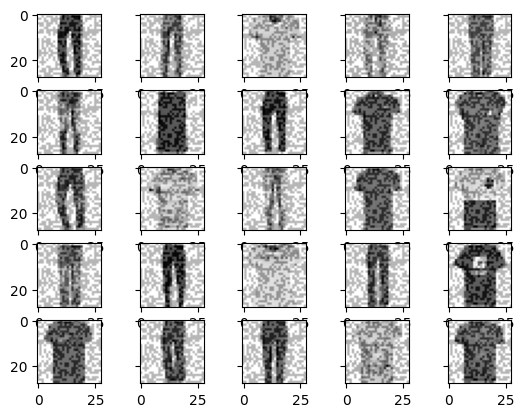

In [4]:
# Fonction pour l'entraînement avec des attaques adversariales
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        yp = model((X - (2 * y.float()[:, None, None, None] - 1) * delta).view(X.shape[0], -1))[:, 0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y == 0) + (yp < 0) * (y == 1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Calcul des erreurs avec perturbation
print(epoch_adv(test_loader, model, delta[None, None, :, :]))

# Visualiser plusieurs images modifiées adversarialement
f, ax = plt.subplots(5, 5, sharey=True)
for i in range(25):
    ax[i % 5][i // 5].imshow(1 - (X_test[i].view(28, 28) - (2 * y_test[i] - 1) * delta).numpy(), cmap="gray")
plt.show()

In [5]:
# Fonction d'entraînement robuste avec perturbations adversariales
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        yp = model(X.view(X.shape[0], -1))[:, 0] - epsilon * (2 * y.float() - 1) * model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_err += ((yp > 0) * (y == 0) + (yp < 0) * (y == 1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.579750	1.906998	0.622500	1.463641
0.580000	1.763013	0.579500	1.296807
0.570417	1.663174	0.573500	2.359443
0.566000	1.635358	0.396000	1.025454
0.561167	1.585945	0.574000	2.528536
0.543083	1.499369	0.566500	1.603904
0.555333	1.508478	0.392500	1.133009
0.529667	1.444736	0.559000	1.648797
0.533750	1.523079	0.611500	1.375526
0.516083	1.459329	0.367500	1.119552
0.503333	1.395680	0.382500	1.085209
0.520000	1.445607	0.490000	1.386458
0.512083	1.452349	0.347000	1.029480
0.501750	1.358814	0.606500	1.590029
0.514583	1.443154	0.614500	1.453197
0.516417	1.410390	0.615500	1.406000
0.506667	1.394690	0.494000	1.109444
0.506417	1.355967	0.614000	1.321311
0.505667	1.432848	0.600500	2.007661
0.485500	1.367942	0.320500	0.929573
Train Err	Train Loss	Test Err	Test Loss
0.181167	0.475837	0.186500	0.487391


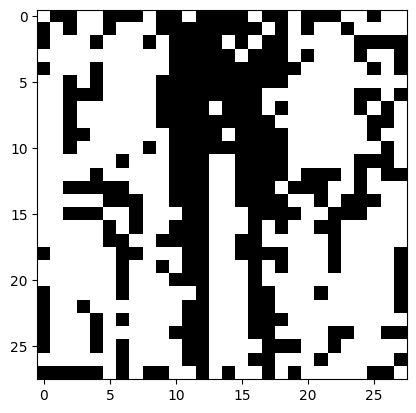

In [6]:
# Entraînement avec la méthode robuste
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

# Évaluer le modèle sans perturbations adversariales
train_err, train_loss = epoch_adv(train_loader, model, delta)
test_err, test_loss = epoch_adv(test_loader, model, delta)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

# Visualisation de la perturbation adversariale appliquée
delta = epsilon * model.weight.detach().sign().view(28, 28)
plt.imshow(1 - delta.numpy(), cmap="gray")
plt.show()

 Le modèle montre une robustesse modérée face aux perturbations adversariales, mais il est encore affecté par une erreur relativement élevée sur les exemples perturbés.

# **Chapter 3 - Adversarial examples, solving the inner maximization**

On utilise le jeu de données Fashion-MNIST à la place de MNIST.

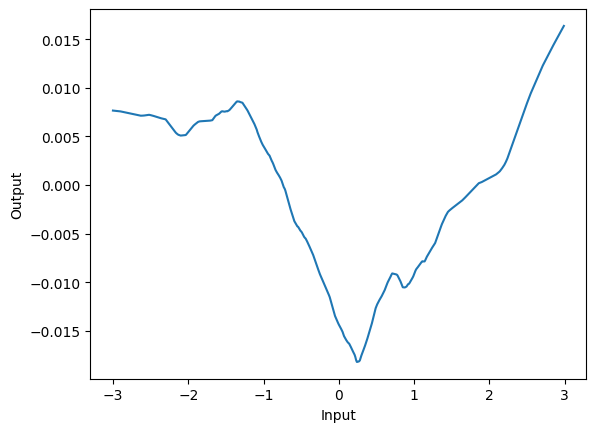

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Définir le dispositif d'exécution (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fixer la graine aléatoire pour la reproductibilité
torch.manual_seed(0)

# Définir le modèle simple (régression avec 3 couches cachées)
model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(),
                      nn.Linear(100, 100), nn.ReLU(),
                      nn.Linear(100, 100), nn.ReLU(),
                      nn.Linear(100, 1))
opt = optim.SGD(model.parameters(), lr=1e-2)

# Entraîner le modèle simple sur des données aléatoires
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100, 1)), torch.randn(100, 1))
    opt.zero_grad()
    loss.backward()
    opt.step()

# Visualisation des résultats
import numpy as np
plt.plot(np.arange(-3, 3, 0.01), model(torch.arange(-3, 3, 0.01)[:, None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()



In [11]:
# Définir la classe Flatten
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# Définir les modèles DNN et CNN pour Fashion-MNIST
model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784, 200), nn.ReLU(),
                            nn.Linear(200, 10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784, 200), nn.ReLU(),
                            nn.Linear(200, 100), nn.ReLU(),
                            nn.Linear(100, 100), nn.ReLU(),
                            nn.Linear(100, 10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7 * 7 * 64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)





 Jeu de données Fashion-MNIST

In [12]:
# Charger les données Fashion-MNIST
fashion_train = datasets.FashionMNIST("../data", train=True, download=True, transform=transforms.ToTensor())
fashion_test = datasets.FashionMNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(fashion_train, batch_size=100, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=100, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.4MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.59MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.35MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [13]:
# Fonction pour effectuer une passe d'entraînement/évaluation
def epoch(loader, model, opt=None):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp, y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Entraîner le modèle DNN à 2 couches et afficher les résultats
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


0.234850	0.681968	0.179100	0.506035
0.165200	0.468369	0.160100	0.454937
0.149583	0.419808	0.152500	0.427599
0.138967	0.389479	0.154800	0.427615
0.132067	0.370086	0.143500	0.408602
0.127217	0.355514	0.138400	0.389878
0.123517	0.340382	0.138500	0.389538
0.119833	0.330478	0.131600	0.367896
0.115950	0.319437	0.133300	0.375912
0.112833	0.310162	0.130200	0.361733
